   Unnamed: 0.1  Unnamed: 0            Timestamp  Trip ID_first   
0           0.0         0.0  2023-01-02 08:52:00   1.401000e+16  \
1           1.0         1.0  2023-01-02 08:53:00   1.401000e+16   
2           2.0         2.0  2023-01-02 08:54:00   1.401000e+16   
3           3.0         3.0  2023-01-02 08:55:00   1.401000e+16   
4           4.0         4.0  2023-01-02 08:56:00   1.401000e+16   

   Segment_first  Latitude_mean  Longitude_mean  Bearing_mean  Speed_mean   
0            1.0       0.966157        0.000000      0.473253    0.540160  \
1            2.0       0.981893        0.108832      0.385957    0.678589   
2            2.0       0.825265        0.132648      0.451557    0.390051   
3            3.0       0.676002        0.188835      0.473374    0.453628   
4            4.0       0.558461        0.188866      0.499302    0.635867   

   Speed_max  
0       11.4  
1       10.3  
2       10.0  
3        9.4  
4       10.0  
Trip ID: 1.4010000626967368e+16, Group size:

/Users/siri2001/IdeaProjects/Python2023/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


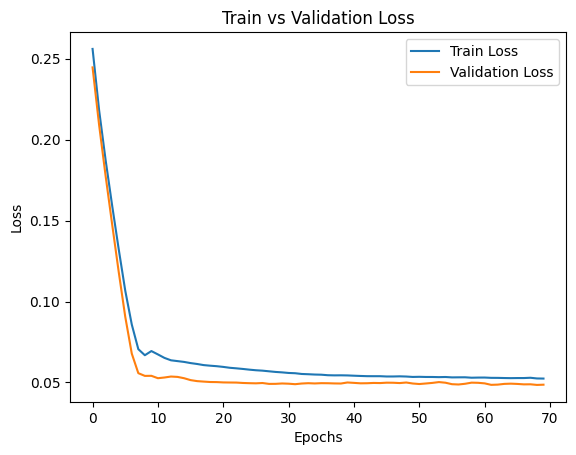

2/2 [==============================] - 0s 2ms/step


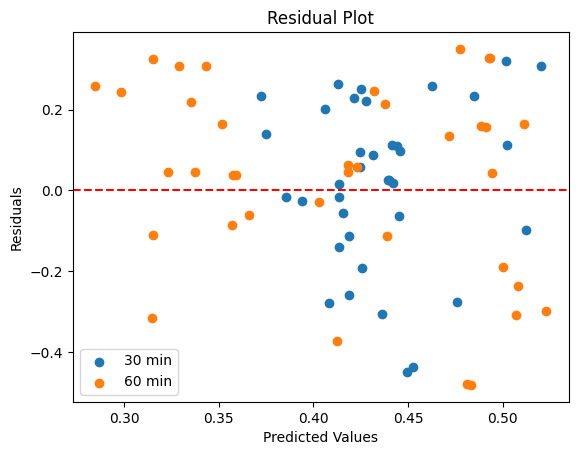

In [86]:
from Data_Prep.createSequence import createSequence
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import dump


# Load the data from the file system
#resampled_df_unclean = pd.read_csv('./Data_Prep/trainData3.csv')
file_name = ['trainData3.csv','trainData4.csv','2023-01-09_resampled.csv','2023-01-09_resampled.csv','2023-11-20_resampled.csv', '2023-11-22_resampled.csv', '2023-11-23_resampled.csv', '2023-11-24_resampled.csv']

resampled_df = pd.concat([pd.read_csv(file) for file in file_name])
resampled_df = resampled_df.dropna()

# Define features to scale
features_to_scale = ['Latitude_mean','Longitude_mean', 'Bearing_mean']
scaler = MinMaxScaler(feature_range=(0, 1))
resampled_df[features_to_scale] = scaler.fit_transform(resampled_df[features_to_scale])
dump(scaler, 'scaler.joblib')

speed_scaler = MinMaxScaler()
speed_data = resampled_df['Speed_mean'].values.reshape(-1, 1)
resampled_df['Speed_mean'] = speed_scaler.fit_transform(speed_data)
dump(speed_scaler, 'speed_scaler.joblib')
print(resampled_df.head())
N = 5  # Number of steps to look back

X, y_30, y_60 = createSequence(N, features_to_scale,resampled_df)
# Convert the lists to NumPy arrays
X = np.array(X)
y_30 = np.array(y_30)
y_60 = np.array(y_60)
y = np.column_stack((y_30, y_60))
print(X.shape)
print(X)


 # Number of steps to look back
n_features = X.shape[2]  # Assuming X is your input features array

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Sequential model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(N, X_train.shape[2])))
model.add(LSTM(units=20))
model.add(Dense(units=2))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test))
model.save('model.h5')

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model and create residual plots
y_pred = model.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_pred[:, 0], residuals[:, 0], label='30 min')
plt.scatter(y_pred[:, 1], residuals[:, 1], label='60 min')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()